In [1]:
import datetime
import sys
from kedro.config import ConfigLoader
from kedro.io import DataCatalog
import pandas as pd
import datetime
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
sys.path.append('../')
# Initialise a ConfigLoader
conf_loader = ConfigLoader("/Users/hungryee/PycharmProjects/ASI_GROUP_PROJECT/asi-prj-s20205/conf", env='base')

# Load the data catalog configuration from catalog.yml
conf_catalog = conf_loader.get("catalog.yml")

# Create the DataCatalog instance from the configuration
catalog = DataCatalog.from_config(conf_catalog)

# Load the dataset and print the output
df = catalog.load("bitcoin_historical_data")


2023-01-15 12:31:26.478425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/hungryee/opt/anaconda3/envs/ASI_prj/lib/python3.9/site-packages/kedro/config/common.py:199: UserWarning: Duplicate environment detected! Skipping re-loading from configuration path: /Users/hungryee/PycharmProjects/ASI_GROUP_PROJECT/asi-prj-s20205/conf/base
  warn(


Text(0, 0.5, 'Close')

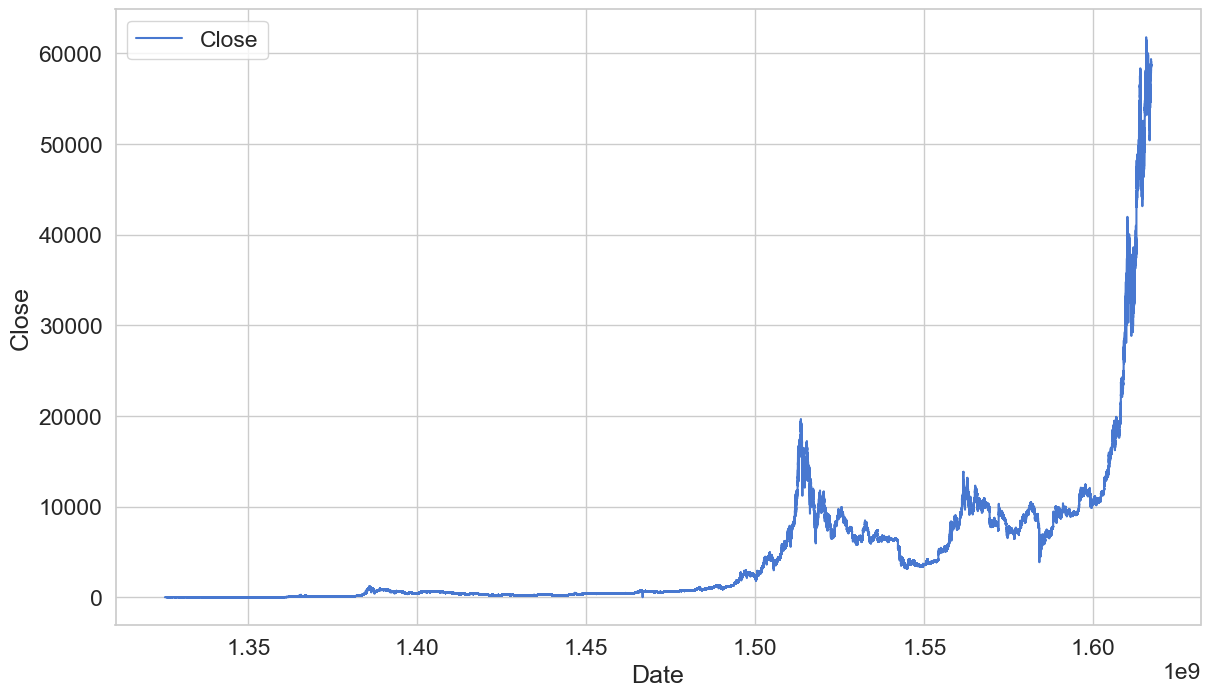

In [2]:

df.head()
ax = df.plot(x='Timestamp', y='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close')


In [3]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)


In [4]:
SEQ_LEN = 100
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)
def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.80)



In [5]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
 input_shape=(99,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True,
 dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

2023-01-15 12:31:44.106261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 99, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 99, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [6]:
BATCH_SIZE = 1024
history = model.fit(
 X_train,
 y_train,
 epochs=1,
 batch_size=BATCH_SIZE,
 shuffle=False,
 validation_split=0.1
)
model.evaluate(X_test, y_test)


22586/22586 [==============================] - 401s 18ms/step - loss: 0.0859


0.08589795231819153

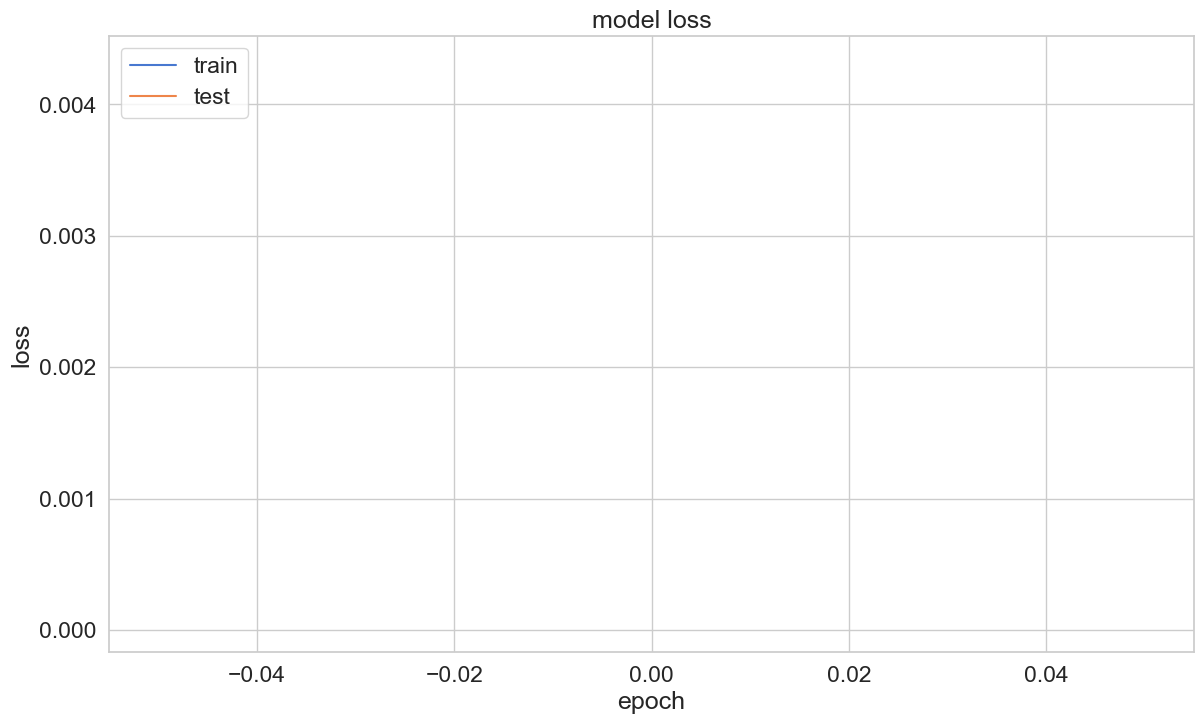

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('saved_models/btc_model')